In [1]:
import pandas as pd
import numpy as np
import re
import matplotlib.pyplot as plt
import matplotlib as mpl
plt.style.use('seaborn')
mpl.rcParams['font.family'] = 'serif'
import seaborn as sns
%matplotlib inline

/home/seb/py36/lib/python3.6/site-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


- Official statistics on total deaths are at: https://opendata.cbs.nl/statline/#/CBS/en/ $\to$ The Netherlands in figures $\to$ Show themes >> $\to$ Population $\to$ Population Development $\to$ Deaths $\to$ Deaths registered weekly, by sex and age

- Official statistics on Covid-19 mortality are at: https://www.rivm.nl/coronavirus-covid-19/grafieken $\to$ Aantal overledenen naar datum van overlijden

# 1) Processing official data on total deaths

## 1.1) Ingesting and reshaping data 1995-2020

In [2]:
df = pd.read_csv('./total_death/Deaths_registered_weekly__by_sex_and_age_13042020_094824.csv', skiprows=5, delimiter=';')

In [3]:
df = df[['Periods', 'aantal']]
df = df[df.Periods != 'Source: CBS']
df['year'] = df['Periods'].str[:4]
df['week'] = df.Periods.apply(lambda x: re.search('[0-9]{4}\sweek\s([0-9]+)', x).group(1))
df['special'] = df.Periods.apply(lambda x: re.search('[0-9]{4}\sweek\s[0-9]+(.*)', x).group(1))
df['deaths'] = df.aantal
df.loc[df.special=='*', 'special'] = ''
df = df.reset_index(drop=True).copy(deep=True)

filling week 1 with week 0 / week 53 of previous years. This is not necessary (we will not need these) but for consistency check with https://www.cbs.nl/nl-nl/nieuws/2020/15/sterfte-neemt-verder-toe . 

In [4]:
def add_discard(df, p1, p2):
    v1 = df[df.Periods == p1].deaths.values[0]
    v2 = df[df.Periods == p2].deaths.values[0]
    df.loc[df.Periods == p2, 'deaths'] = v1+v2
    df = df[df.Periods != p1].reset_index(drop=True).copy(deep=True)
#     print(v1)
#     print(v2)
#     print(v1+v2)
#     print(df.loc[df.Periods == p2].deaths.values[0])
#     print(df.shape)
#     print(df[df.Periods == p1].shape)
#     print(df[df.Periods == p2].shape)
#     print('')
    return df
    

In [5]:
# 1995 has week 0 (1 day) and week 1 with no days qualifier => discard week 0
df = df[df.Periods != '1995 week 0 (1 day)'].reset_index(drop=True).copy(deep=True)

# 1996 has week 53 (2 days) and 1997 has week 1 (5 days) => add 1996-53 to 1997-1 and discard 1996-53
df = add_discard(df, '1996 week 53 (2 days)', '1997 week 1 (5 days)')

# 1997 has week 53 (3 days) and 1998 has week 1 (4 days) => add 1997-53 to 1998-1 and discard 1997-53
df = add_discard(df, '1997 week 53 (3 days)', '1998 week 1 (4 days)')

# 1998 has week 53 (4 days) and 1999 has week 0 (3 days) => add 1999-0 to 1998-53 and discard 1999-0
df = add_discard(df, '1999 week 0 (3 days)', '1998 week 53 (4 days)')

# 1999 has week 52 (5 days) and 2000 has week 0 (2 days) => add 2000-0 to 1999-52 and discard 2000-0
df = add_discard(df, '2000 week 0 (2 days)', '1999 week 52 (5 days)')

# 2001 has week 53 (1 day) and 2002 has week 1 (6 days) => add 2001-53 to 2002-1 and discard 2001-53
df = add_discard(df, '2001 week 53 (1 day)', '2002 week 1 (6 days)')

# 2002 has week 53 (2 days) and 2003 has week 1 (5 days) => add 2002-53 to 2003-1 and discard 2002-53
df = add_discard(df, '2002 week 53 (2 days)', '2003 week 1 (5 days)')

# 2003 has week 53 (3 days) and 2004 has week 1 with very few deaths => add 2003-53 to 2004-1 and discard 2003-53
df = add_discard(df, '2003 week 53 (3 days)', '2004 week 1')

# 2004 has week 53 (5 days) and 2005 has week 0 (2 days) => add 2005-0 to 2004-53 and discard 2005-0
df = add_discard(df, '2005 week 0 (2 days)', '2004 week 53 (5 days)')

# 2005 has week 52 (6 days) and 2006 has week 0 (1 day) => add 2006-0 to 2005-52 and discard 2006-0
df = add_discard(df, '2006 week 0 (1 day)', '2005 week 52 (6 days)')

# 2007 has week 53 (1 day) and 2008 has week 1 (6 days) => add 2007-53 to 2008-1 and discard 2007-53
df = add_discard(df, '2007 week 53 (1 day)', '2008 week 1 (6 days)')

# 2008 has week 53 (3 days) and 2009 has week 1 (4 days) => add 2008-53 to 2009-1 and discard 2008-53
df = add_discard(df, '2008 week 53 (3 days)', '2009 week 1 (4 days)')

# 2009 has week 53 (4 days) and 2010 has week 0 (3 days) => add 2010-0 to 2009-53 and discard 2010-0
df = add_discard(df, '2010 week 0 (3 days)', '2009 week 53 (4 days)')

# 2010 has week 52 (5 days) and 2011 has week 0 (2 days) => add 2011-0 to 2010-52 and discard 2011-0
df = add_discard(df, '2011 week 0 (2 days)', '2010 week 52 (5 days)')

# 2011 has week 52 (6 days) and 2012 has week 0 (1 day) => add 2012-0 to 2011-52 and discard 2012-0
df = add_discard(df, '2012 week 0 (1 day)', '2011 week 52 (6 days)')

# 2012 has week 53 and 2013 week 1 has very few deaths => add 2012-53 to 2013-1 and discard 2012-53
df = add_discard(df, '2012 week 53', '2013 week 1')

# 2013 has week 53 (2 days) and 2014 has week 1 (5 days) => add 2013-53 to 2014-1 and discard 2013-53
df = add_discard(df, '2013 week 53 (2 days)', '2014 week 1 (5 days)')

# 2014 has week 53 (3 days) and 2015 has week 1 (4 days) => add 2014-53 to 2015-1 and discard 2014-53
df = add_discard(df, '2014 week 53 (3 days)', '2015 week 1 (4 days)')

# 2015 has week 53 (4 days) and 2016 has week 0 (3 days) => add 2016-0 to 2015-53 and discard 2016-0
df = add_discard(df, '2016 week 0 (3 days)', '2015 week 53 (4 days)')

# 2016 has week 52 (6 days) and 2017 has week 0 (1 day) => add 2017-0 to 2016-52 and discard 2017-0
df = add_discard(df, '2017 week 0 (1 day)', '2016 week 52 (6 days)')

# 2018 has week 53 (1 day) and 2019 has week 1 (6 days) => add 2018-53 to 2019-1 and discard 2018-53
df = add_discard(df, '2018 week 53 (1 day)', '2019 week 1 (6 days)*')

# 2019 has week 53 (2 days) and 2020 has week 1 (5 days) => add 2019-53 to 2020-1 and discard 2019-53
df = add_discard(df, '2019 week 53 (2 days)*', '2020 week 1 (5 days)*')

In [6]:
print(df[df.deaths != df.aantal].shape)
print(df[df.special != ''].shape)
# df.to_csv('./total_death/week_harmonized.csv', index=False)

(21, 6)
(19, 6)


In [7]:
df = df[['year', 'week', 'deaths']]

In [8]:
df['week'] = df.week.astype(int)
df.index = [df.week, df.year]
df = df.drop(['year', 'week'], axis=1)
df = df.unstack()
df.columns = df.columns.droplevel()
df.reset_index(inplace=True)
df.columns = ['week'] + ['{}'.format(yr) for yr in range(1995, 2021)]
df = df[['week'] + ['{}'.format(yr) for yr in range(2015, 2021)]]
df = df[~pd.isnull(df['2020'])].reset_index(drop=True).copy(deep=True)

## 1.2) Consistency-checking processed data with data from second (already formated) source

https://www.cbs.nl/nl-nl/nieuws/2020/15/sterfte-neemt-verder-toe

In [9]:
consist = pd.read_csv('./total_death/table_tabel-a9ca1888-20b4-4086-8bee-083422a60e98.csv')

In [10]:
consist = consist.iloc[:14,1:]
cols = ['c_{}'.format(yr) for yr in range(2017, 2021)]
consist.columns = cols
consist['week'] = np.arange(1,15)
consist = consist[['week'] + cols]

In [11]:
df = pd.merge(df, consist, on='week', how='inner')
for yr in range(2017, 2021):
    df['d_{}'.format(yr)] = df['{}'.format(yr)] - df['c_{}'.format(yr)]
    del df['c_{}'.format(yr)]
# df
for yr in range(2017, 2021):
    del df['d_{}'.format(yr)]

## 1.3) Constructing countefactual

first official covid-19 death is in week 10 $\to$ discard all observations before week 9

In [12]:
df = df[df.week >= 9].reset_index(drop=True).copy(deep=True)

computing cumulative sums

In [13]:
for yr in range(2015, 2021):
    df['cs_{}'.format(yr)] = df['{}'.format(yr)].cumsum()
    del df['{}'.format(yr)]

computing daily growth rates

In [14]:
for yr in range(2015, 2020):
    df['gr_{}'.format(yr)] = df['cs_{}'.format(yr)] / df['cs_{}'.format(yr)].shift(1)
    del df['cs_{}'.format(yr)]

computing average of daily growth rates 15-19

In [15]:
df['daily_growth'] = df.loc[:,['gr_{}'.format(yr) for yr in range(2015,2020)]].mean(axis=1)
df = df.drop(['gr_{}'.format(yr) for yr in range(2015,2020)], axis=1)

extrapolating forward

In [16]:
df['counterfactual'] = 0
df.loc[0,'counterfactual'] = df.loc[df.week==9,'cs_2020'].values[0]

In [17]:
for i in range(1, df.shape[0]):
    df.loc[i,'counterfactual'] = df.loc[i-1,'counterfactual'] * df.loc[i,'daily_growth']

In [18]:
df = df.drop(['daily_growth'], axis=1)

# 2) Processing the official Covid-19 death data

In [19]:
official = pd.read_csv('./covid_deaths/overledenen-per-dag.csv')
cal = pd.read_csv('./covid_deaths/day_month_week_2020.csv')

In [20]:
official['covid_deaths'] = official['nieuw'] + official['tot en met gisteren']
official['str_mon'] = official['Datum van overlijden'].apply(lambda x: re.search('[0-9]+\s([a-z]{3})', x).group(1))
official['month'] = 0
official.loc[official.str_mon=='feb', 'month'] = 2
official.loc[official.str_mon=='mrt', 'month'] = 3
official.loc[official.str_mon=='apr', 'month'] = 4
official['day'] = official['Datum van overlijden'].apply(lambda x: int(re.search('([0-9]+)\s.+', x).group(1)))
official = official[['day', 'month', 'covid_deaths']]
official = pd.merge(cal, official, on=['day', 'month'], how='inner')
official['day'] = ('0' + official.day.astype('str')).str[-2:]
official['month'] = ('0' + official.month.astype('str')).str[-2:]
official['date'] = '2020-' + official.month + '-' + official.day
official = official[['week', 'date', 'covid_deaths']]
wks = official[['week', 'date']]
wks = wks.groupby('week').last().reset_index(drop=False).copy(deep=True)
official = official.groupby('week').sum()
official.reset_index(inplace=True)
official['covid_deaths'] = official.covid_deaths.cumsum()
official = pd.merge(official, wks, on=['week'], how='inner')

# 3) Merging and plotting

In [21]:
df = pd.merge(df, official, on=['week'], how='left')
df = df.fillna(0)
df['counterfactual_2020_covid'] = df.counterfactual + df.covid_deaths
df = df.drop(['covid_deaths', 'week'], axis=1)
df.index = df.date
del df['date']

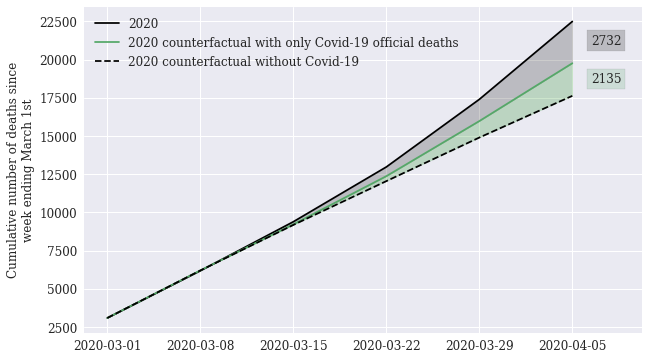

In [22]:
palette = sns.color_palette()

f = plt.figure(figsize=(10,6))
ax = plt.subplot(1,1,1)

ax.plot(df.index,
        df['cs_2020'],
        label='2020',
        color='black')
ax.plot(df.index,
        df['counterfactual_2020_covid'],
        label='2020 counterfactual with only Covid-19 official deaths',
        color = palette[1])
ax.plot(df.index,
        df['counterfactual'],
        label='2020 counterfactual without Covid-19',
        color='black', 
        linestyle = '--')

ax.set_xticks(df.index[[0,1,2,3,4,5]])
ax.fill_between(df.index, df['cs_2020'], df['counterfactual_2020_covid'], color='black', alpha='0.2')
ax.fill_between(df.index, df['counterfactual_2020_covid'], df['counterfactual'], color='green', alpha='0.2')

ax.set_ylabel('Cumulative number of deaths since\nweek ending March 1st',size=12)
ax.tick_params(axis='both', which='major', labelsize=12)

ax.legend(loc='upper left',
          fontsize=12)

plot_margin = 0.5

x0, x1, y0, y1 = plt.axis()
plt.axis((x0,
          x1 + plot_margin,
          y0,
          y1))

plt.text(5.2, 18500, '{}'.format(int(round(df.iloc[-1, 2] - df.iloc[-1, 1]))),
         bbox=dict(facecolor=palette[1], alpha=0.2), size=12)


plt.text(5.2, 21000, '{}'.format(int(round(df.iloc[-1, 0] - df.iloc[-1, 2]))),
         bbox=dict(facecolor='black', alpha=0.2), size=12)

plt.show()

f.savefig('_netherlands.pdf', bbox_inches='tight', dpi=100)

In [23]:
print('Official covid-deaths: {} = green - dashed black'.format(round(df.iloc[-1, 2] - df.iloc[-1, 1])))
print('Excess deaths: {} = solid black - dashed black'.format(round(df.iloc[-1, 0] - df.iloc[-1, 1])))
print('Unexplained excess deaths: {} = solid black - green'.format(round(df.iloc[-1, 0] - df.iloc[-1, 2])))

Official covid-deaths: 2135.0 = green - dashed black
Excess deaths: 4867.0 = solid black - dashed black
Unexplained excess deaths: 2732.0 = solid black - green
